In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-09-06 19:25:20.190775: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-09-06 19:25:20.200950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.ae_mlp import AE_MLP
from src.models.som import SOM

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

Предобработанные данные, т.к. в исходных датасетах неочевидная временнАя метка

In [6]:
data_train = pd.read_csv("/opt/datasets/cerebrum/TimeSeries/WADI/data2019_train.csv", index_col=[0], parse_dates=True)
display(data_train.head())

data_test = pd.read_csv("/opt/datasets/cerebrum/TimeSeries/WADI/data2019_test.csv", index_col=[0], parse_dates=True)
data_test = data_test.rename(columns={'Attack LABLE (1:No Attack, -1:Attack)': 'anomaly'})
data_test['anomaly'] = data_test['anomaly'].apply(lambda x: 0 if x==1 else 1)

display(data_test.head())

,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_001_STATUS,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW
2017-09-25 18:00:01,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:02,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:03,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,1,...,1,1,1,1,1,1,1,67.9651,1,0.68
2017-09-25 18:00:04,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,1,67.1948,1,0.68
2017-09-25 18:00:05,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,1,...,1,1,1,1,1,1,1,67.1948,1,0.68


,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,1_MV_001_STATUS,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,anomaly
2017-10-09 18:00:01,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:02,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:03,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:04,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2017-10-09 18:00:05,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,0.0,48.482,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0


In [7]:
df_train, df_test = prepare_data(data_train, data_test)

deleting NaN features: Index(['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS'], dtype='object')

deleting constant features: ['1_LS_001_AL', '1_LS_002_AL', '1_P_002_STATUS', '1_P_004_STATUS', '2_MV_001_STATUS', '2_MV_002_STATUS', '2_MV_004_STATUS', '2_MV_005_STATUS', '2_MV_009_STATUS', '2_P_004_STATUS', '2_SV_101_STATUS', '2_SV_201_STATUS', '2_SV_301_STATUS', '2_SV_401_STATUS', '2_SV_501_STATUS', '2_SV_601_STATUS', '3_LS_001_AL', '3_MV_001_STATUS', '3_MV_002_STATUS', '3_MV_003_STATUS', '3_P_001_STATUS', '3_P_002_STATUS', '3_P_003_STATUS', '3_P_004_STATUS', 'PLANT_START_STOP_LOG']


In [8]:
bad_col = ['3_AIT_002_PV', '2B_AIT_002_PV']

In [9]:
summary = {}

## Подготовка train/test

In [10]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)


Standard scaler 
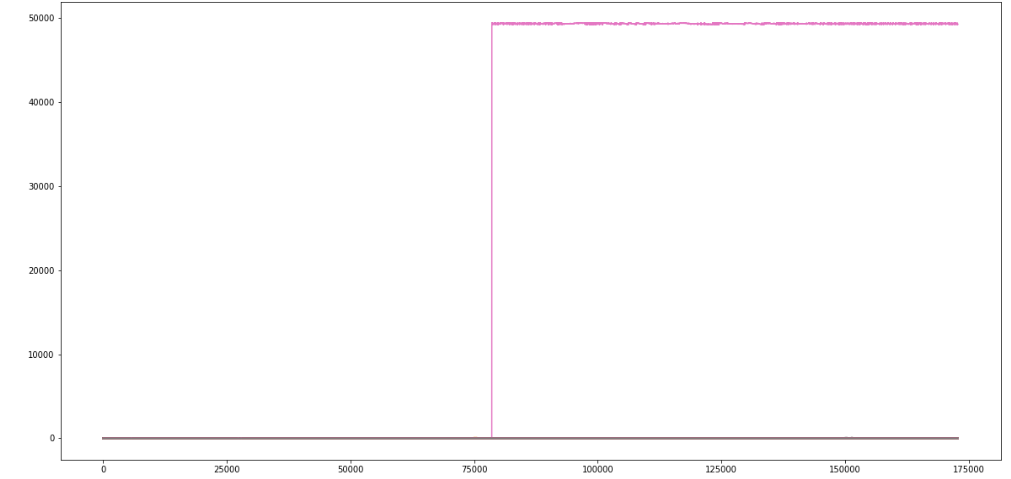

MinMax scaler
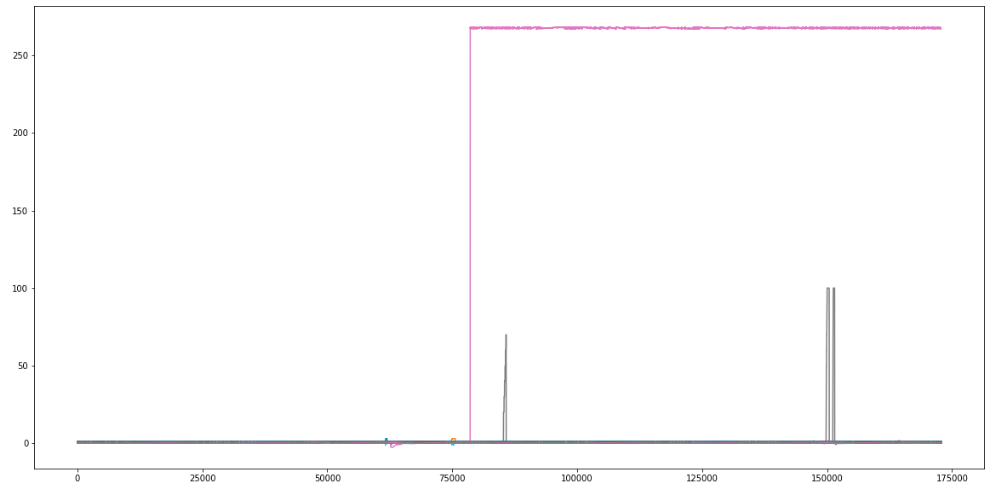

## OC SVM

In [11]:
description='WADI_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

2022-09-06 19:25:59.469654: find saved model: ./saved_models/WADI_svm_default, loading...


WADI_svm_default
f1_score: 0.10
accuracy_score: 0.45
precision_score: 0.05
recall_score: 0.51


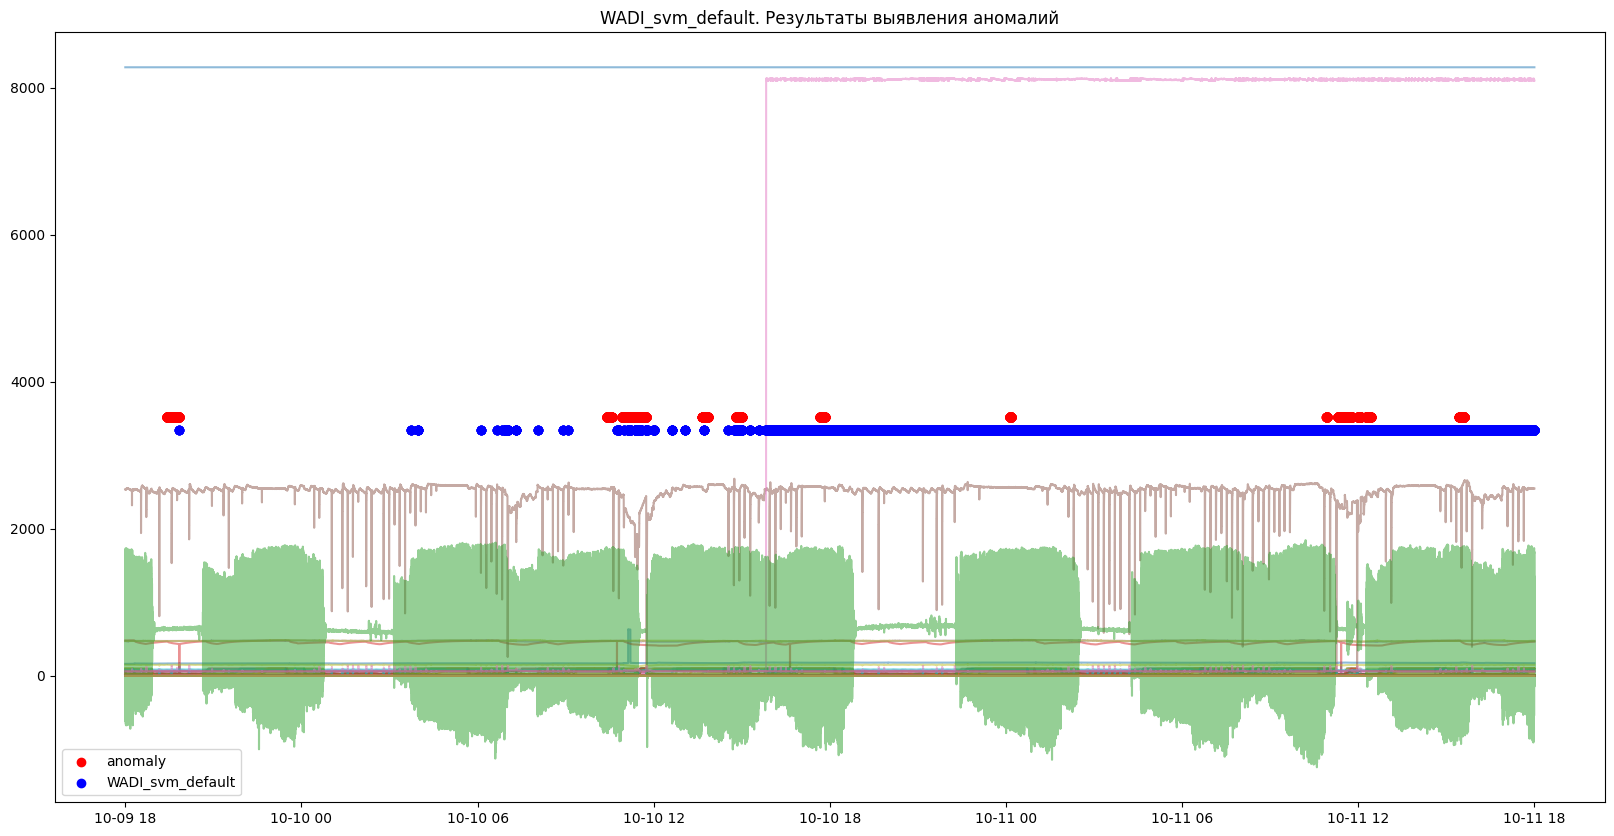

In [12]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Удаление плохих признаков

In [13]:
bad_col

['3_AIT_002_PV', '2B_AIT_002_PV']

In [14]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


2022-09-06 19:27:46.672543: find saved model: ./saved_models/WADI_svm_wo_badcol, loading...
WADI_svm_wo_badcol
f1_score: 0.39
accuracy_score: 0.95
precision_score: 0.71
recall_score: 0.27


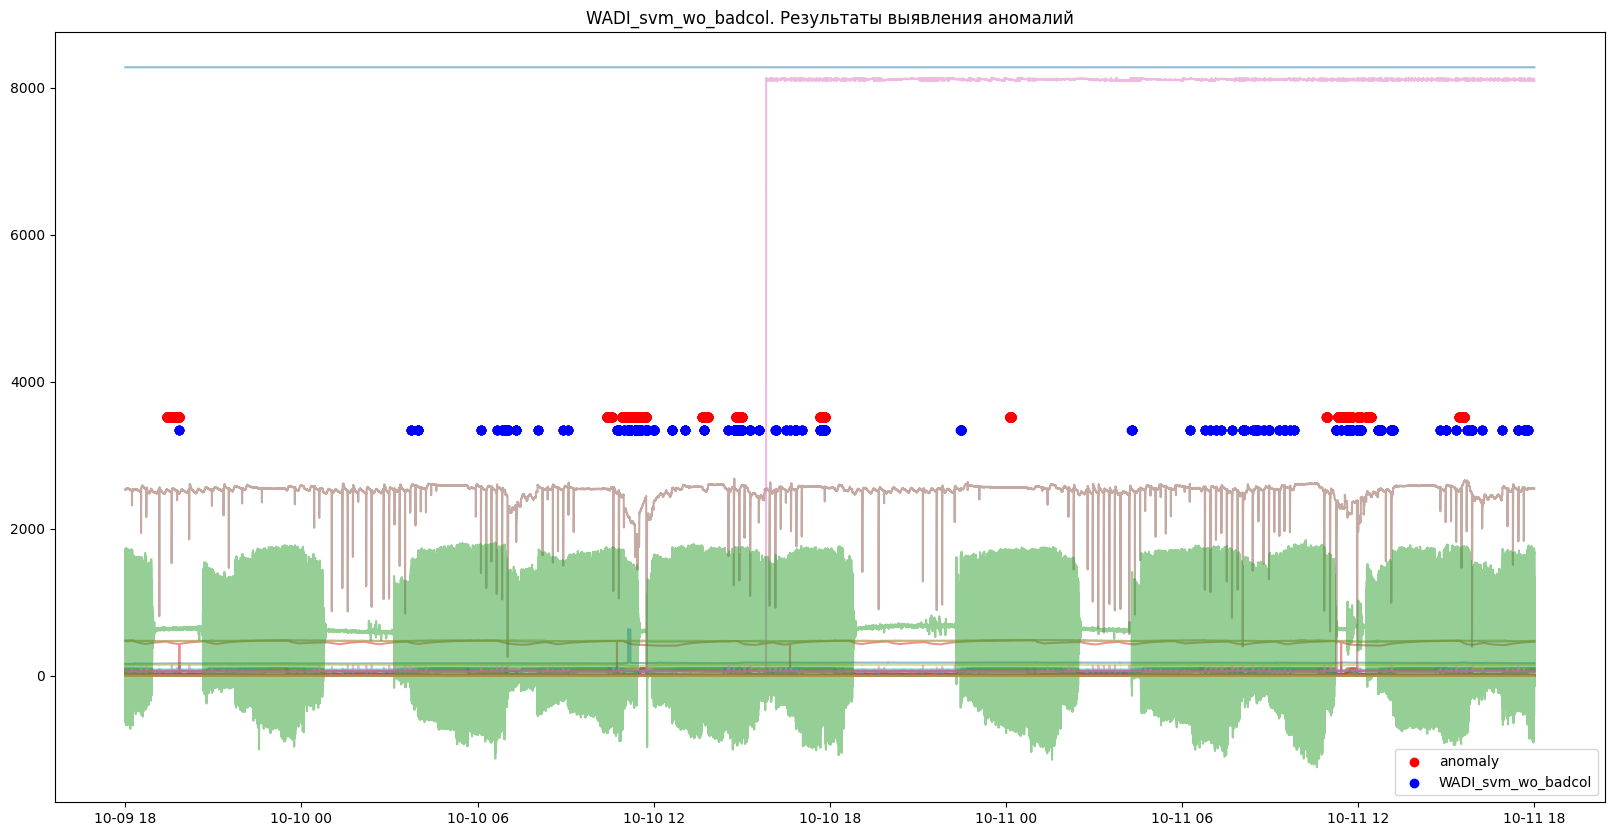

In [15]:
description='WADI_svm_wo_badcol'
predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)
2022-09-06 19:30:03.561188: find saved model: ./saved_models/WADI_svm_wo_badcol_minmax, loading...
WADI_svm_wo_badcol_minmax
f1_score: 0.48
accuracy_score: 0.95
precision_score: 0.58
recall_score: 0.42


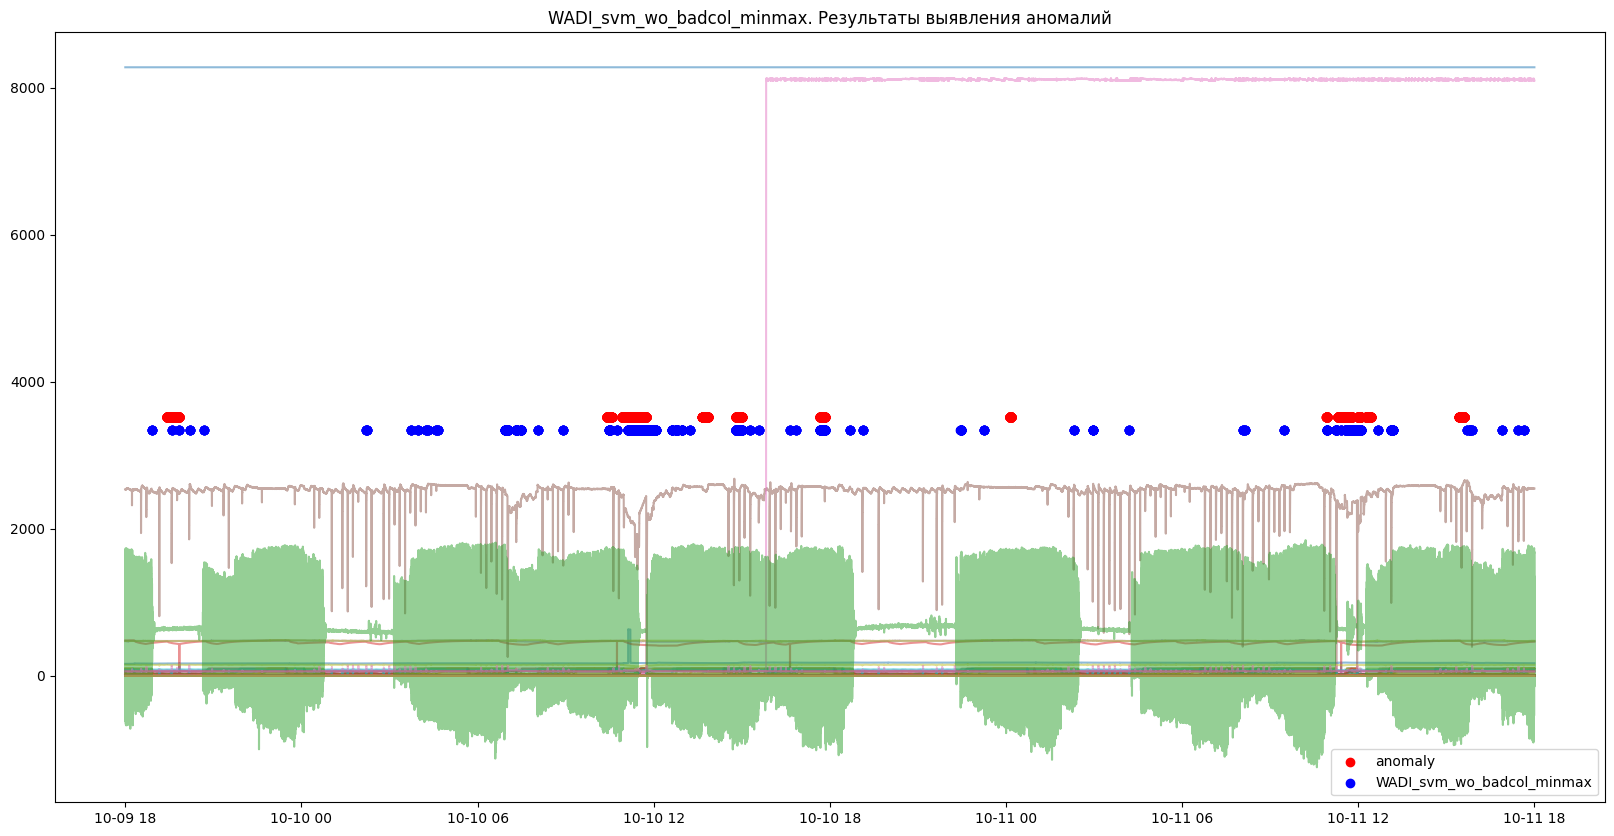

In [16]:
description='WADI_svm_wo_badcol_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [17]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [18]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


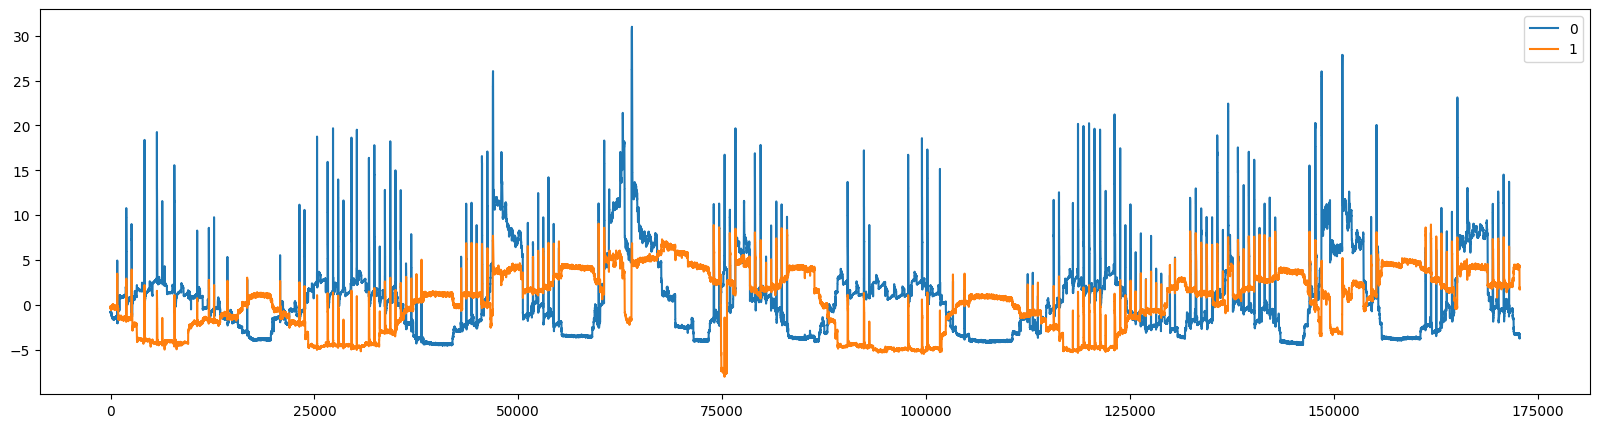

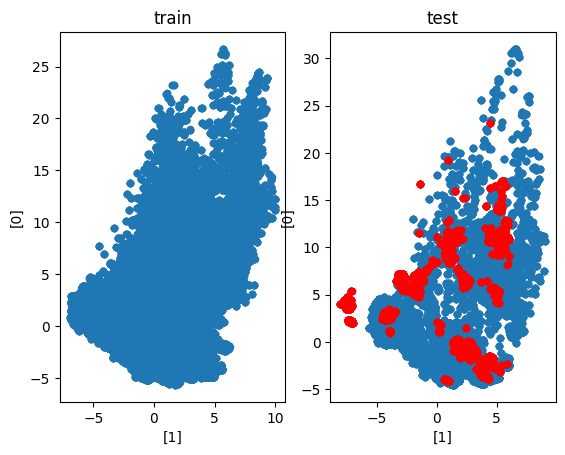

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

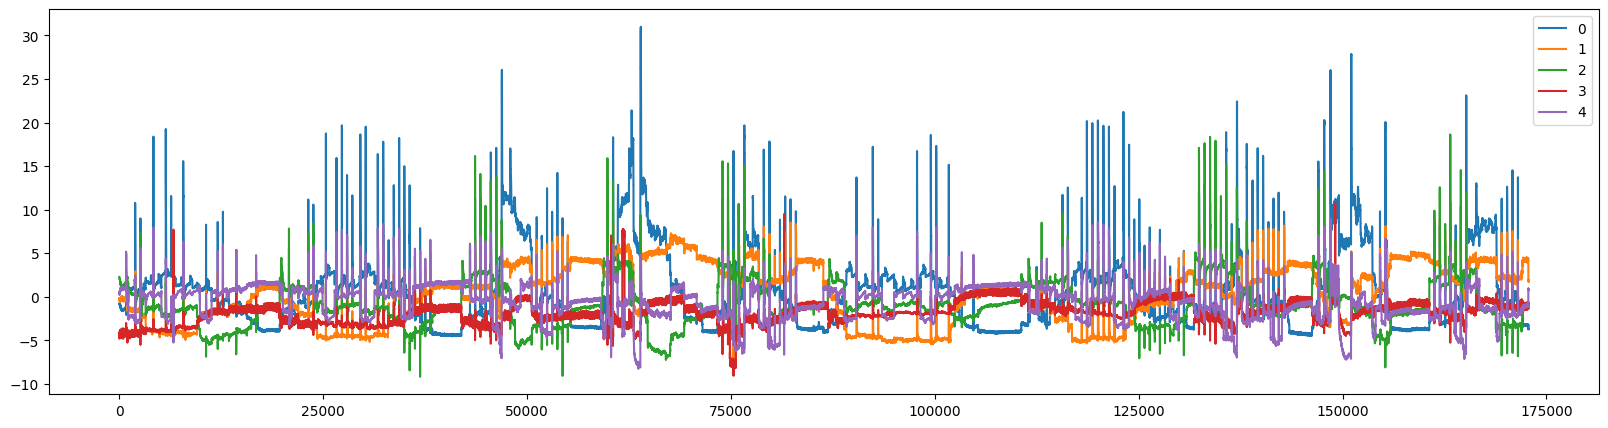

In [20]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [21]:
model = LOF()

2022-09-06 19:31:54.121418: find saved model: ./saved_models/WADI_lof_wo_badcol_n5, loading...
Train prediction score statistics
            min: -89.40114420436835
            mean: -1.1007585901678245
            max: -0.8197151373449355


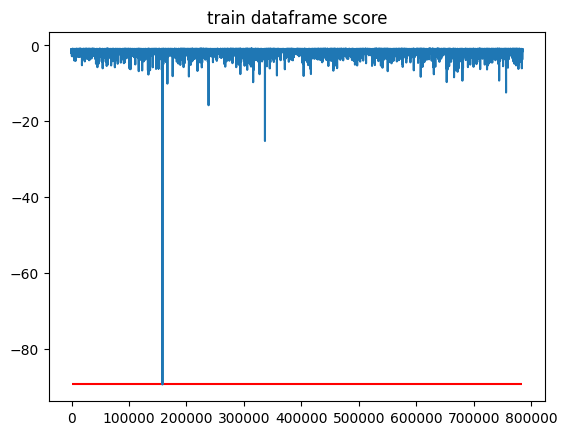

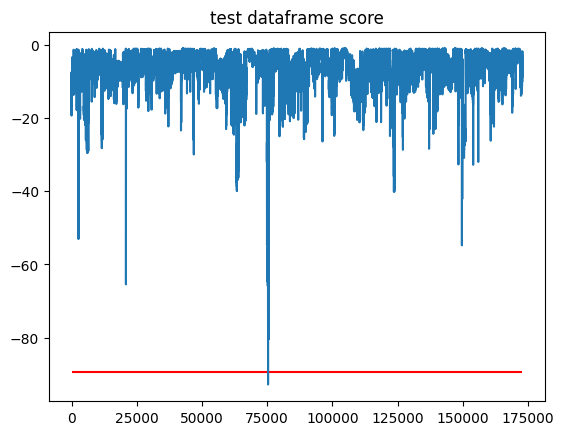

WADI_lof_wo_badcol_n5
f1_score: 0.00
accuracy_score: 0.94
precision_score: 1.00
recall_score: 0.00


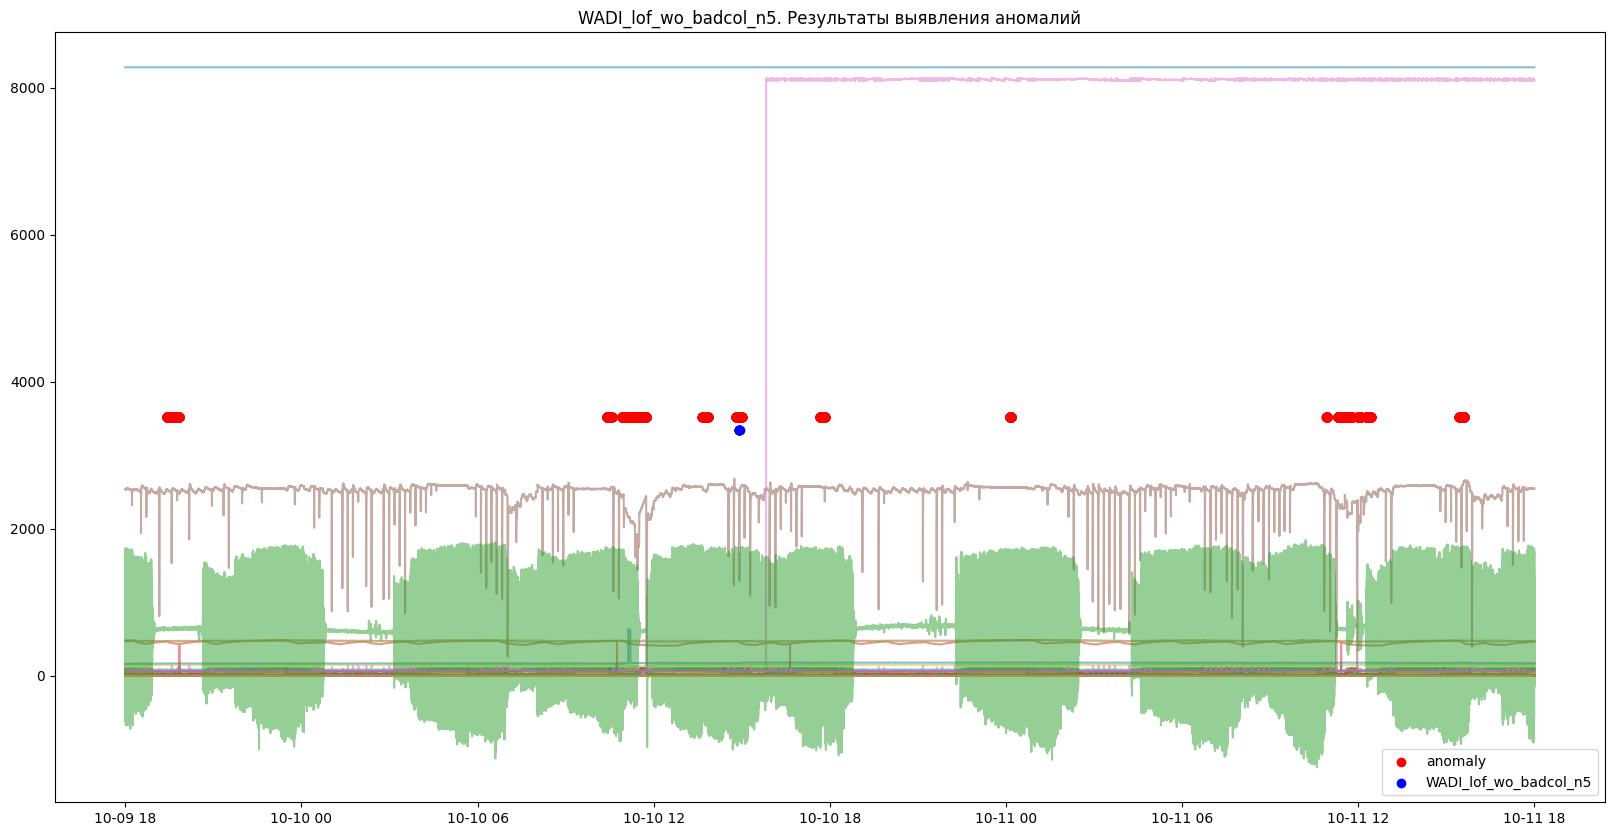

In [22]:
description = f'WADI_lof_wo_badcol_n{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

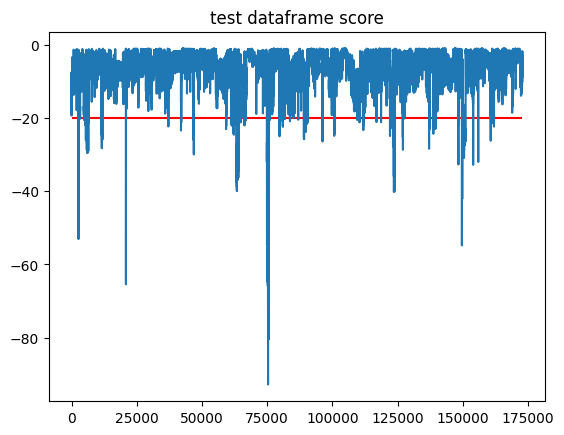

WADI_lof_wo_badcol_n5
f1_score: 0.33
accuracy_score: 0.94
precision_score: 0.52
recall_score: 0.24


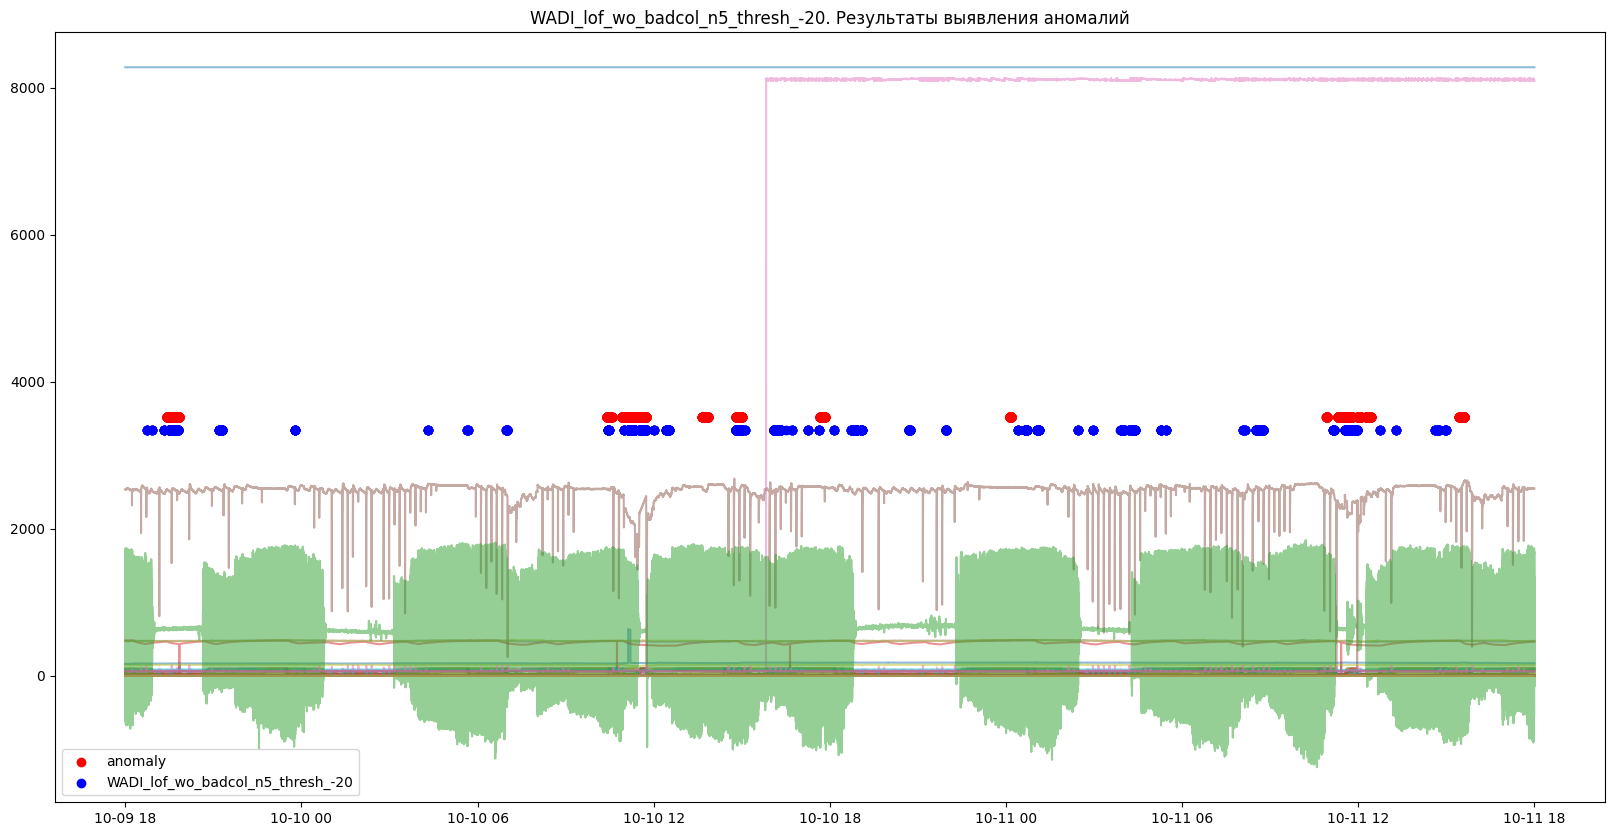

In [23]:
threshold=-20

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f"{description}_thresh_{threshold}"] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f"{description}_thresh_{threshold}")

## iForest

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)
2022-09-06 19:33:25.075717: find saved model: ./saved_models/WADI_iF_default, loading...
WADI_iF_default
f1_score: 0.00
accuracy_score: 0.94
precision_score: 0.03
recall_score: 0.00


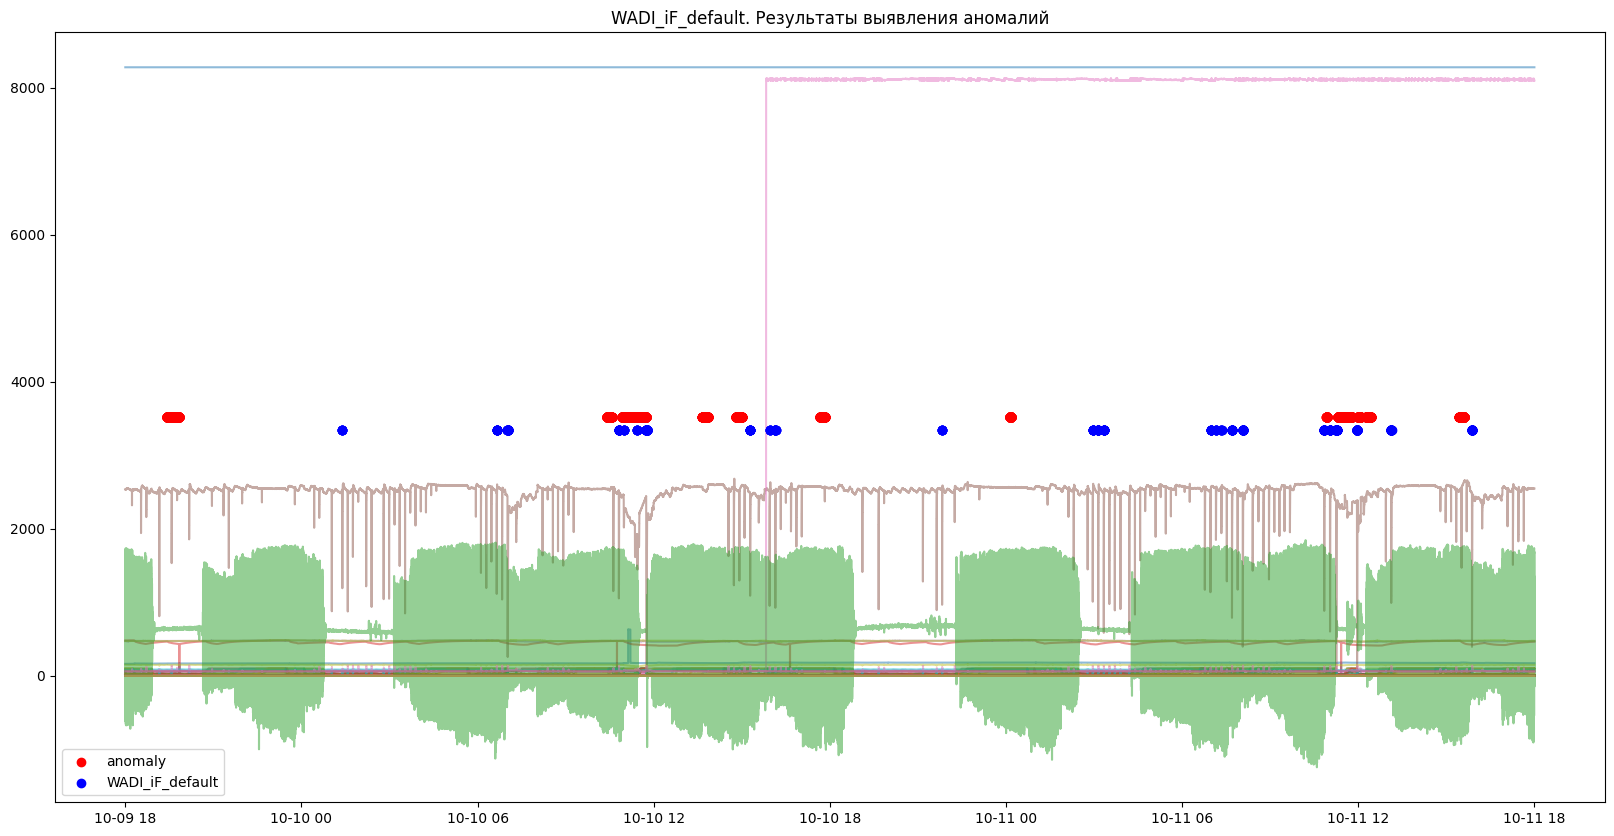

In [24]:
description = f'WADI_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)
2022-09-06 19:33:43.281332: refit model...
SWAT_Jul19_iF_n_98_c_004
f1_score: 0.30
accuracy_score: 0.90
precision_score: 0.25
recall_score: 0.38


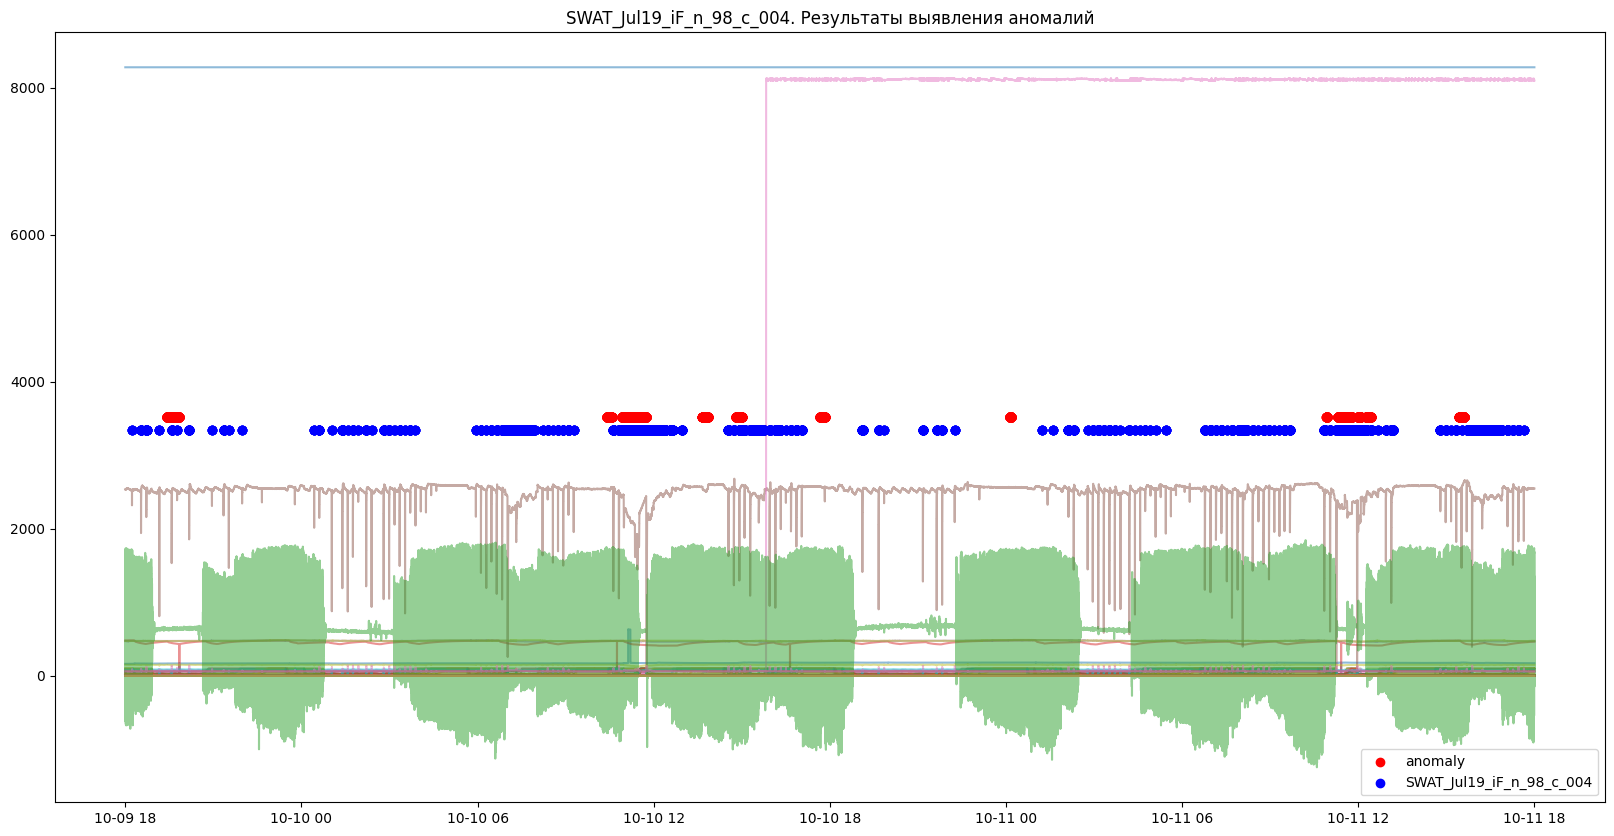

In [25]:
n_estimators, contamination = 98, 0.04

description = f"SWAT_Jul19_iF_n_{n_estimators}_c_{str(contamination).replace('.','')}"

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=n_estimators, contamination=contamination)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Resampling... (T)
(1667, 98), (2881, 98), (2881,),
Create sequences with window size 10...
Размеры выборок:
            x_train: (99991, 10, 98)
            x_test: (172792, 10, 98)
            y_test: (172792, 10)
2022-09-06 19:35:18.107873: find saved model: ./saved_models/WADI_ae_lstm_window10_resample_T, loading...


2022-09-06 19:35:18.011903: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-06 19:35:18.034921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 19:35:18.036049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.8GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-09-06 19:35:18.036183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 19:35:18.036884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:

Train prediction score statistics
            min: 7.79662253389634
            mean: 19.989917980631166
            max: 1865.040350121108


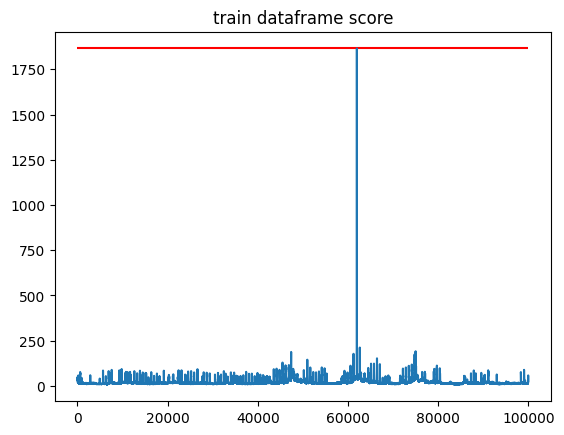

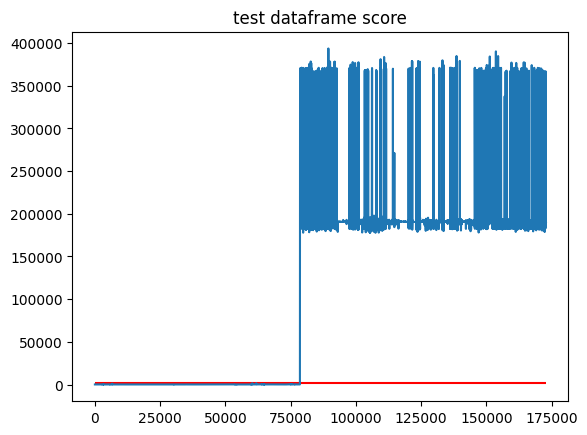

(172792,)
WADI_ae_lstm_window10_resample_T
f1_score: 0.08
accuracy_score: 0.44
precision_score: 0.04
recall_score: 0.39


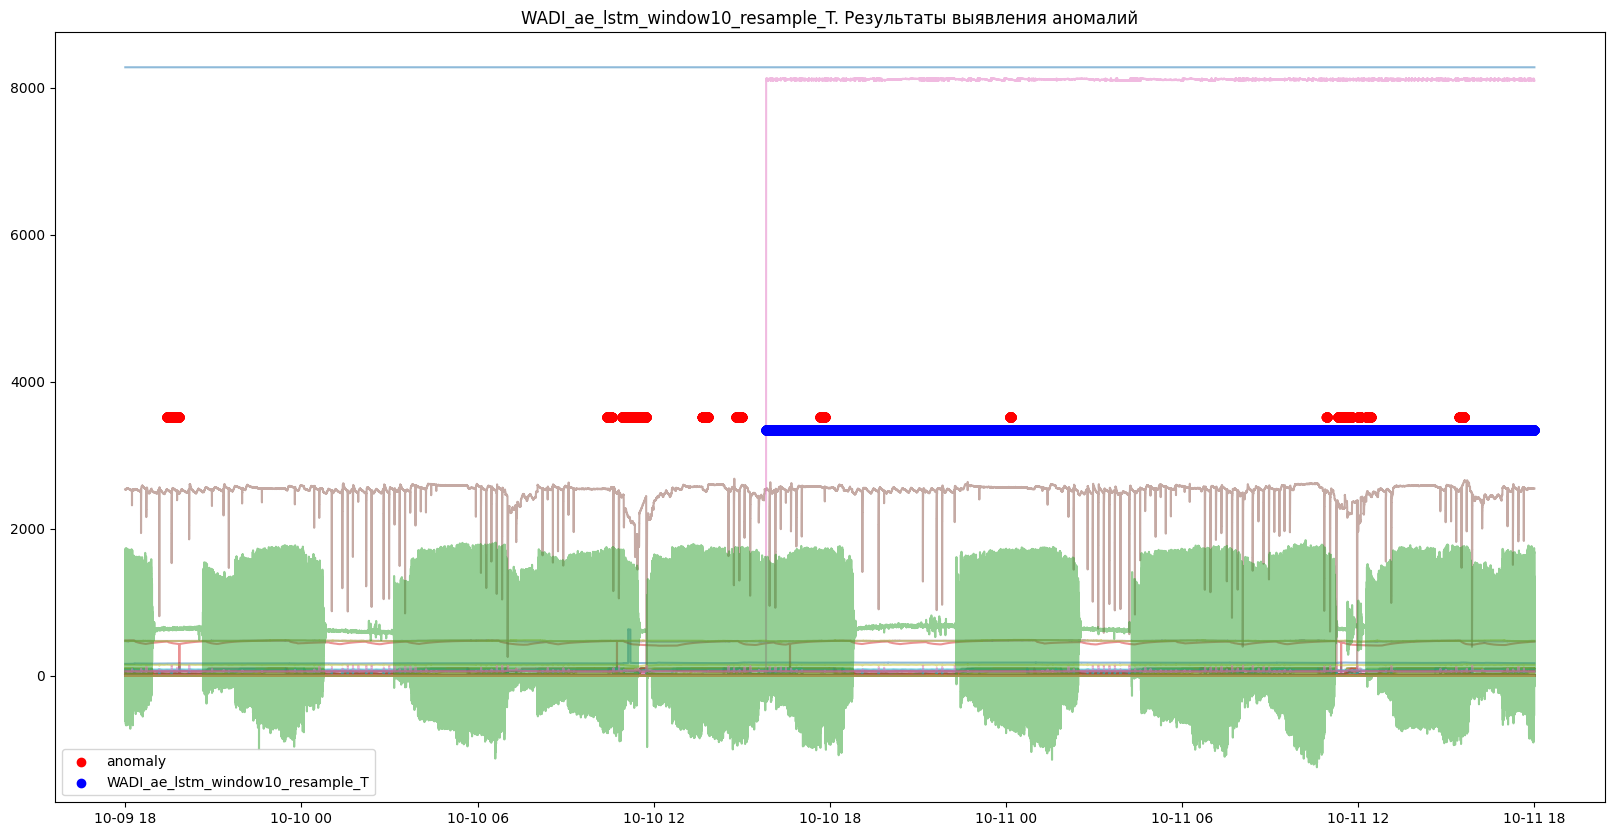

In [26]:
window_size = 10
resample_rate = 'T'

description = f'WADI_ae_lstm_window{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train[:100000].copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

In [27]:
window_size = 10
resample_rate = '1T'

description = f'WADI_ae_lstm_wo_badcol_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train[:100_000].copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Resampling... (1T)
(1667, 96), (2881, 96), (2881,),
Create sequences with window size 10...
Размеры выборок:
            x_train: (99991, 10, 96)
            x_test: (172792, 10, 96)
            y_test: (172792, 10)


2022-09-06 19:37:11.961124: find saved model: ./saved_models/WADI_ae_lstm_wo_badcol_window_10_resample_1T, loading...


2022-09-06 19:37:16.928062: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 663521280 exceeds 10% of free system memory.
2022-09-06 19:37:47.378883: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 663521280 exceeds 10% of free system memory.


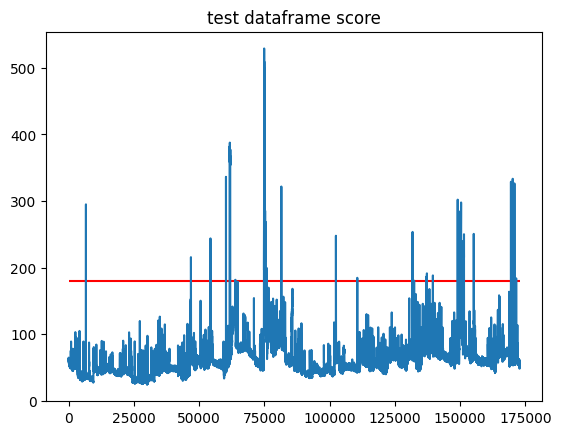

(172792,)
WADI_ae_lstm_wo_badcol_window_10_resample_1T
f1_score: 0.31
accuracy_score: 0.95
precision_score: 0.90
recall_score: 0.19


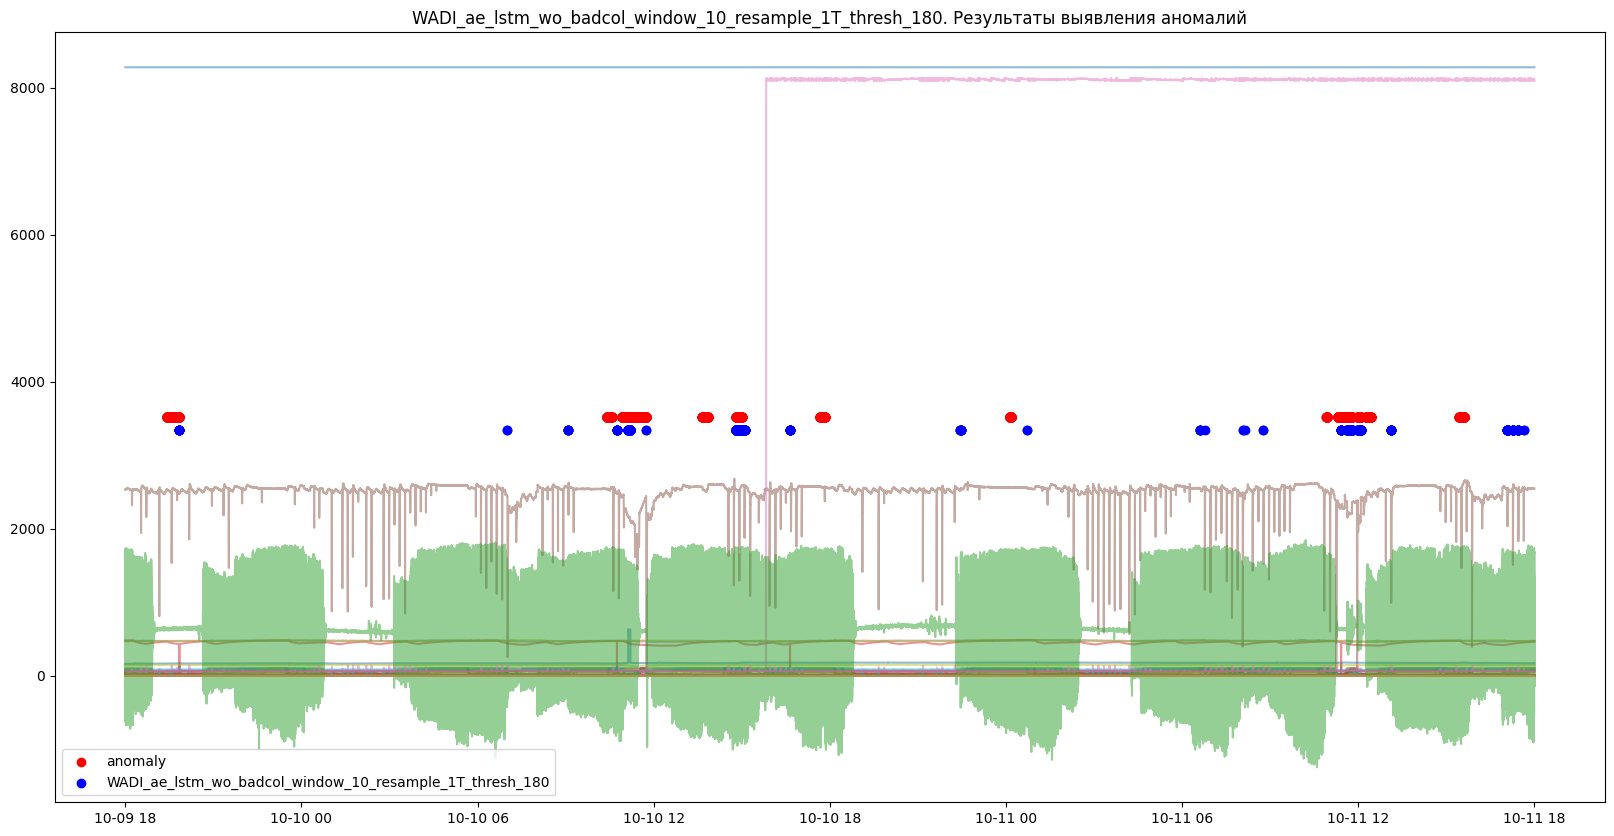

In [28]:
threshold = 180

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f'{description}_thresh_{threshold}')

In [29]:
window_size = 10
resample_rate = '1T'

description = f'WADI_ae_lstm_wo_badcol_window_{window_size}_resample_{resample_rate}_minmax'

x_train, x_test, y_test = get_traintest(df_train[:100_000].copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate,
                                        scaler='MinMax')

Scaling... (MinMax)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Resampling... (1T)
(1667, 96), (2881, 96), (2881,),
Create sequences with window size 10...
Размеры выборок:
            x_train: (99991, 10, 96)
            x_test: (172792, 10, 96)
            y_test: (172792, 10)


In [30]:
model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

2022-09-06 19:38:39.979140: find saved model: ./saved_models/WADI_ae_lstm_wo_badcol_window_10_resample_1T_minmax, loading...


2022-09-06 19:39:08.091954: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 663521280 exceeds 10% of free system memory.


Train prediction score statistics
            min: 1.5228060878794512
            mean: 3.550834937384152
            max: 14.6033186298443


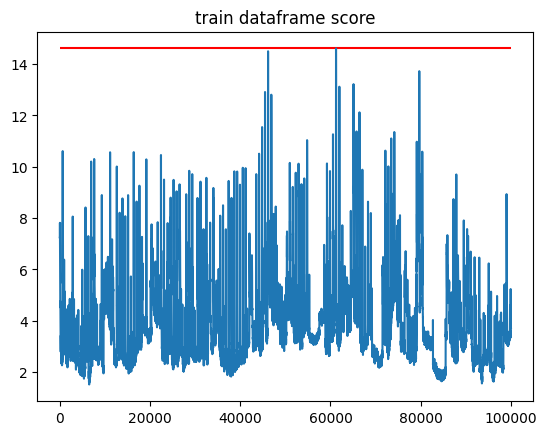

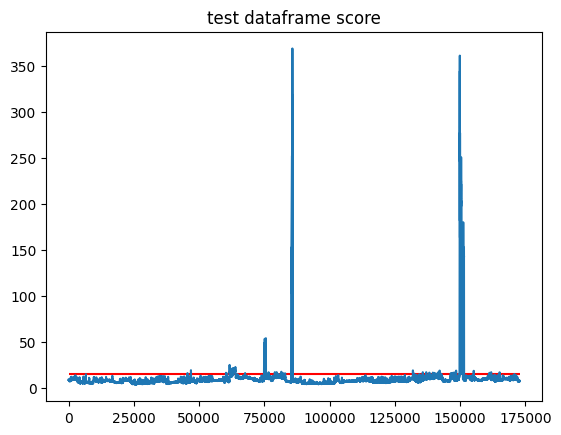

(172792,)
WADI_ae_lstm_wo_badcol_window_10_resample_1T_minmax
f1_score: 0.45
accuracy_score: 0.95
precision_score: 0.68
recall_score: 0.34


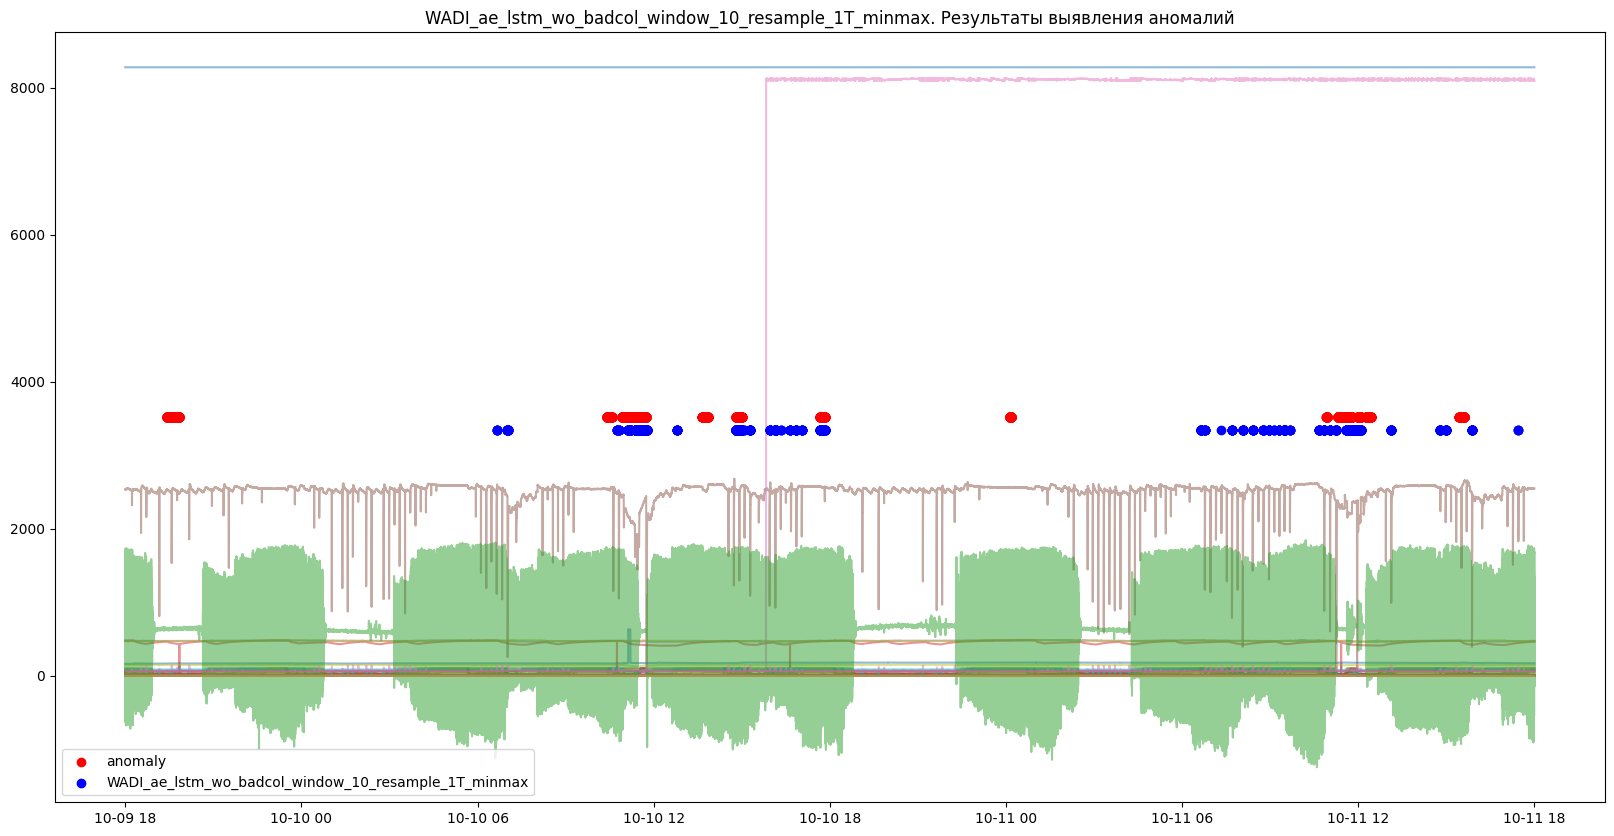

In [31]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

## SOM

In [32]:
x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)


2022-09-06 19:40:27.909416: find saved model: ./saved_models/WADI_som_default, loading...


IntProgress(value=0, description='Computing', max=172801, style=ProgressStyle(bar_color='#61dc8a'))

Train prediction score statistics
            min: 5.220648686035137
            mean: 212.15192075316372
            max: 717.2297612070014


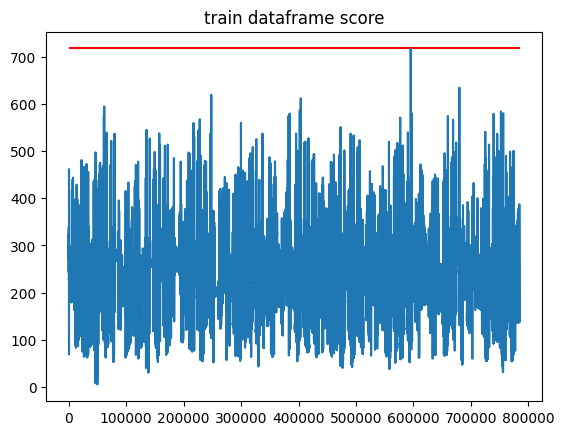

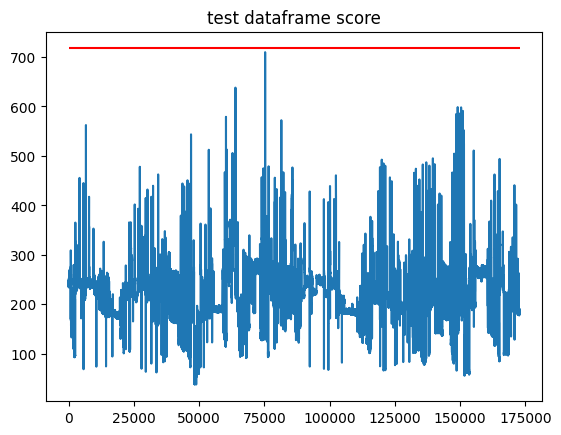

(172801,)
WADI_som_default
f1_score: 0.00
accuracy_score: 0.94
precision_score: 0.00
recall_score: 0.00


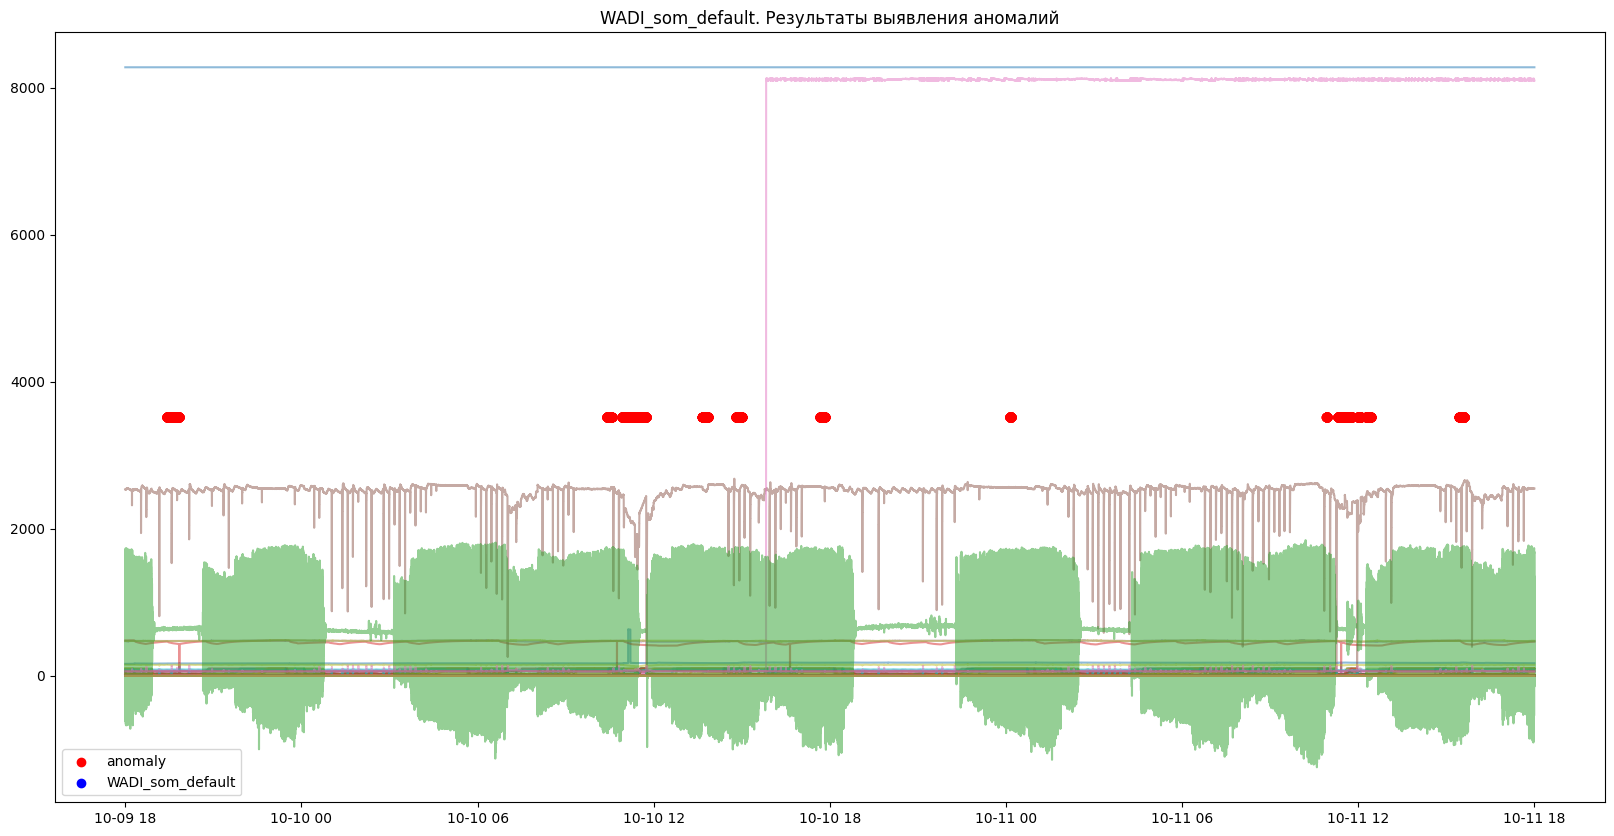

In [33]:
description = f'WADI_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

IntProgress(value=0, description='Computing', max=172801, style=ProgressStyle(bar_color='#61dc8a'))

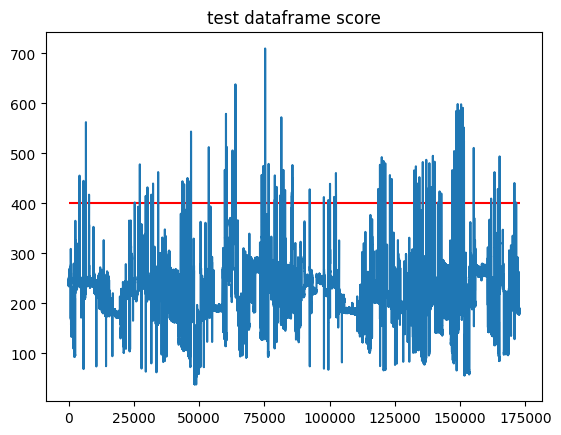

(172801,)
WADI_som_default
f1_score: 0.18
accuracy_score: 0.94
precision_score: 0.49
recall_score: 0.11


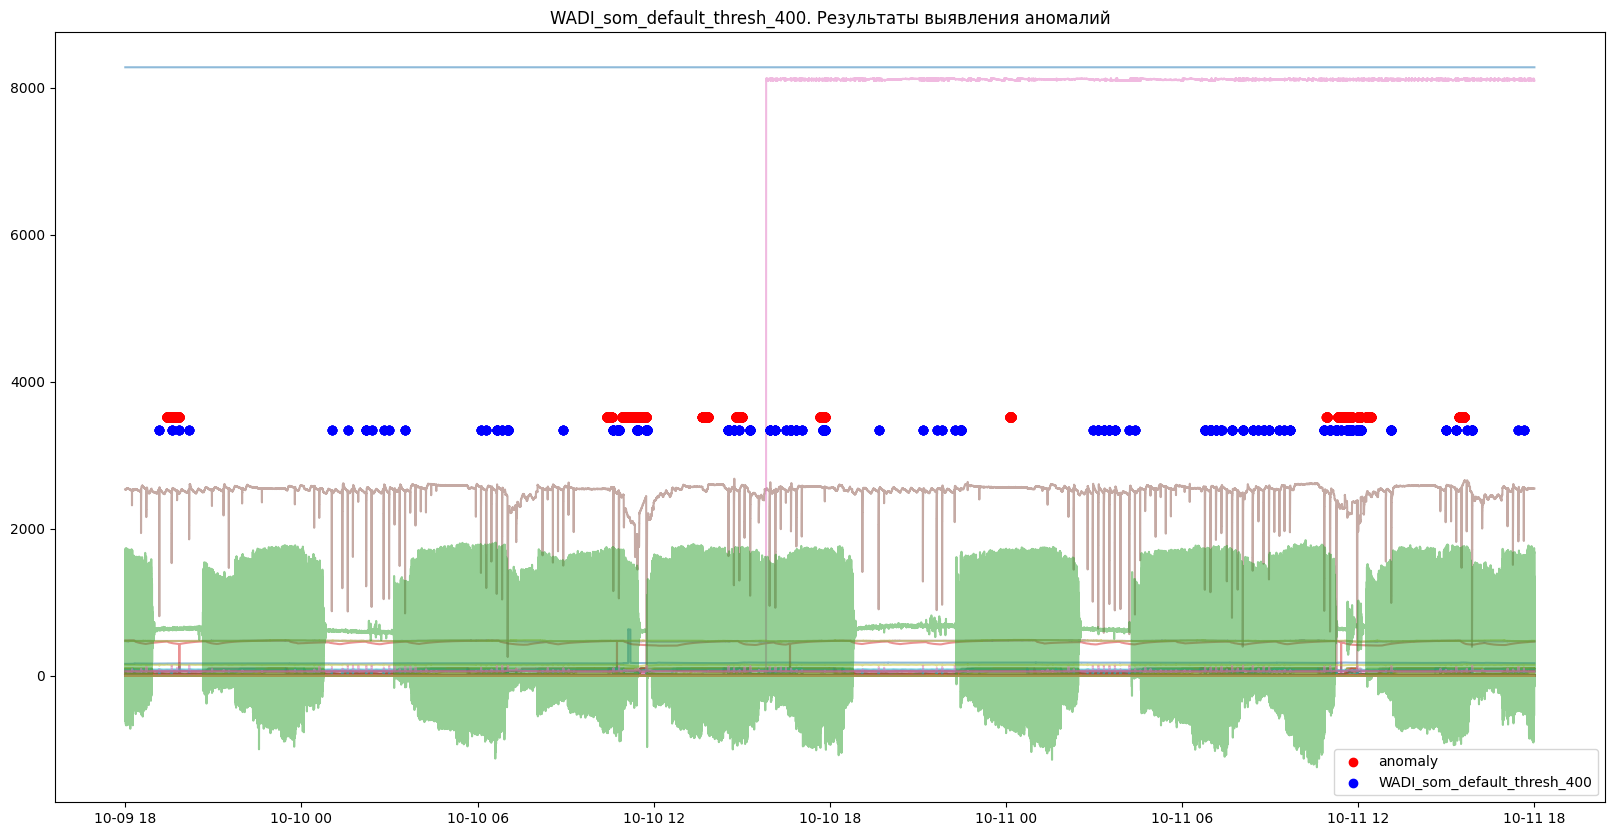

In [34]:
threshold = 400

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f"{description}_thresh_{threshold}"] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f"{description}_thresh_{threshold}")

## Autoencoder MLP

In [35]:
description = f'WADI_ae_mlp_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = AE_MLP()

predictor = Predictor(model, [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 98)
            x_test: (172801, 98)
            y_test: (172801,)
2022-09-06 19:55:37.364670: can't find saved model, fit model...
784537 98
Epoch 1/10
785/785 [==============================] - 3s 3ms/step - loss: 0.8317
Epoch 2/10
785/785 [==============================] - 2s 3ms/step - loss: 0.7417
Epoch 3/10
785/785 [==============================] - 2s 3ms/step - loss: 0.7130
Epoch 4/10
785/785 [==============================] - 2s 3ms/step - loss: 0.7035
Epoch 5/10
785/785 [==============================] - 2s 3ms/step - loss: 0.6978
Epoch 6/10
785/785 [==============================] - 2s 3ms/step - loss: 0.6940
Epoch 7/10
785/785 [==============================] - 2s 3ms/step - loss: 0.6911
Epoch 8/10
785/785 [==============================] - 2s 3ms/step - loss: 0.6892
Epoch 9/10
785/785 [==============================] - 2s 3ms/step - loss: 0.6879
Epo

Train prediction score statistics
            min: 0.344436103141473
            mean: 0.5210080606986051
            max: 2.5093067259931403


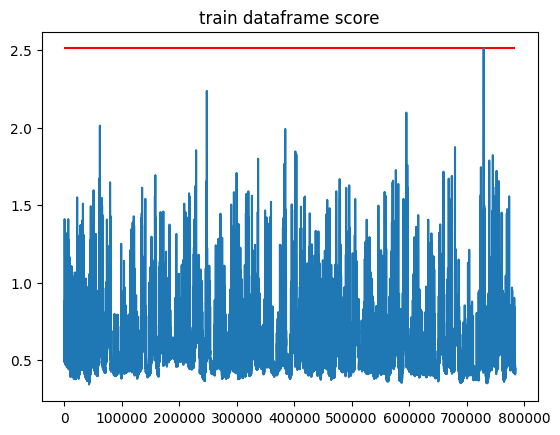

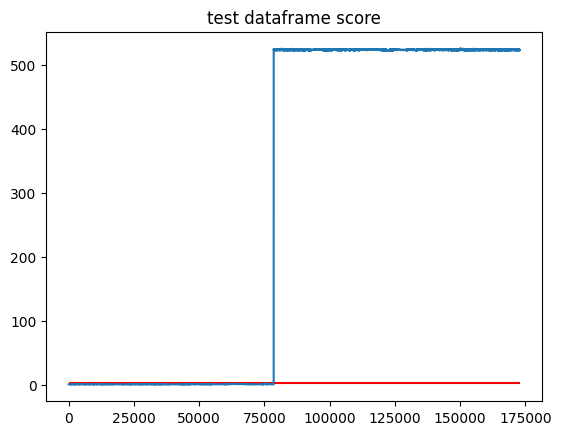

WADI_ae_mlp_default
f1_score: 0.08
accuracy_score: 0.44
precision_score: 0.04
recall_score: 0.39


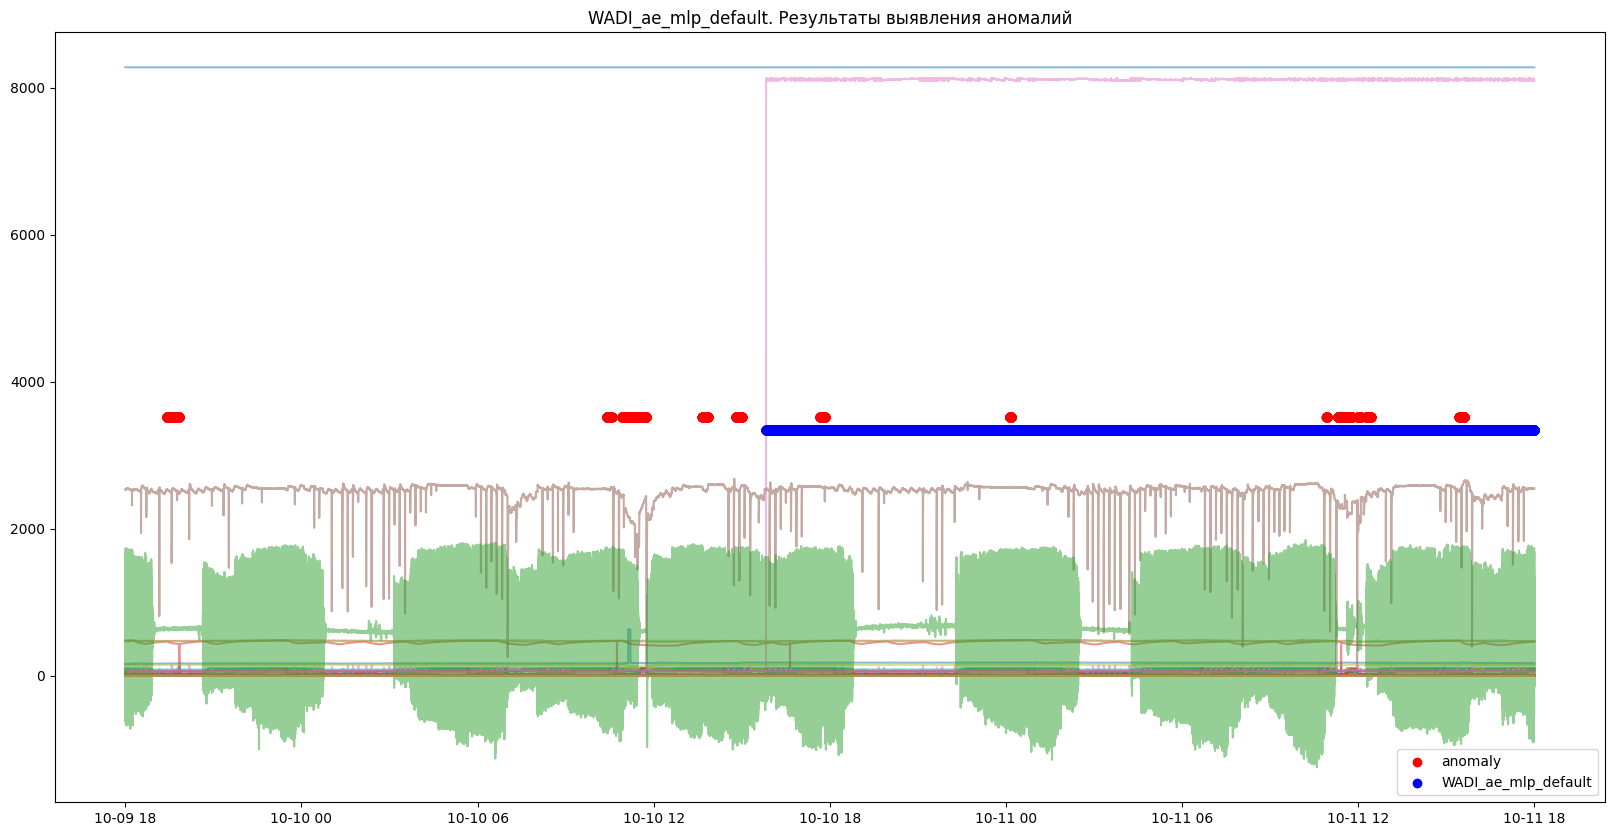

In [36]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

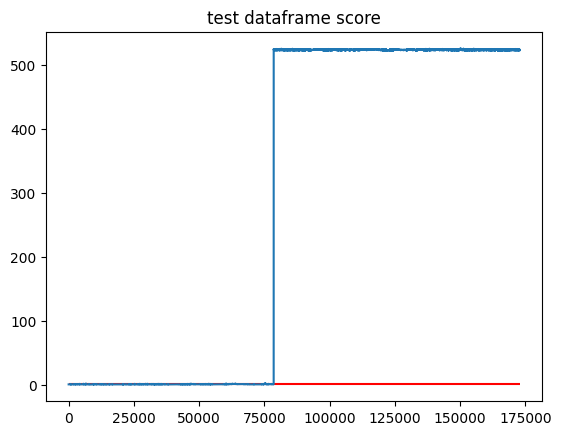

WADI_ae_mlp_default
f1_score: 0.08
accuracy_score: 0.44
precision_score: 0.05
recall_score: 0.44


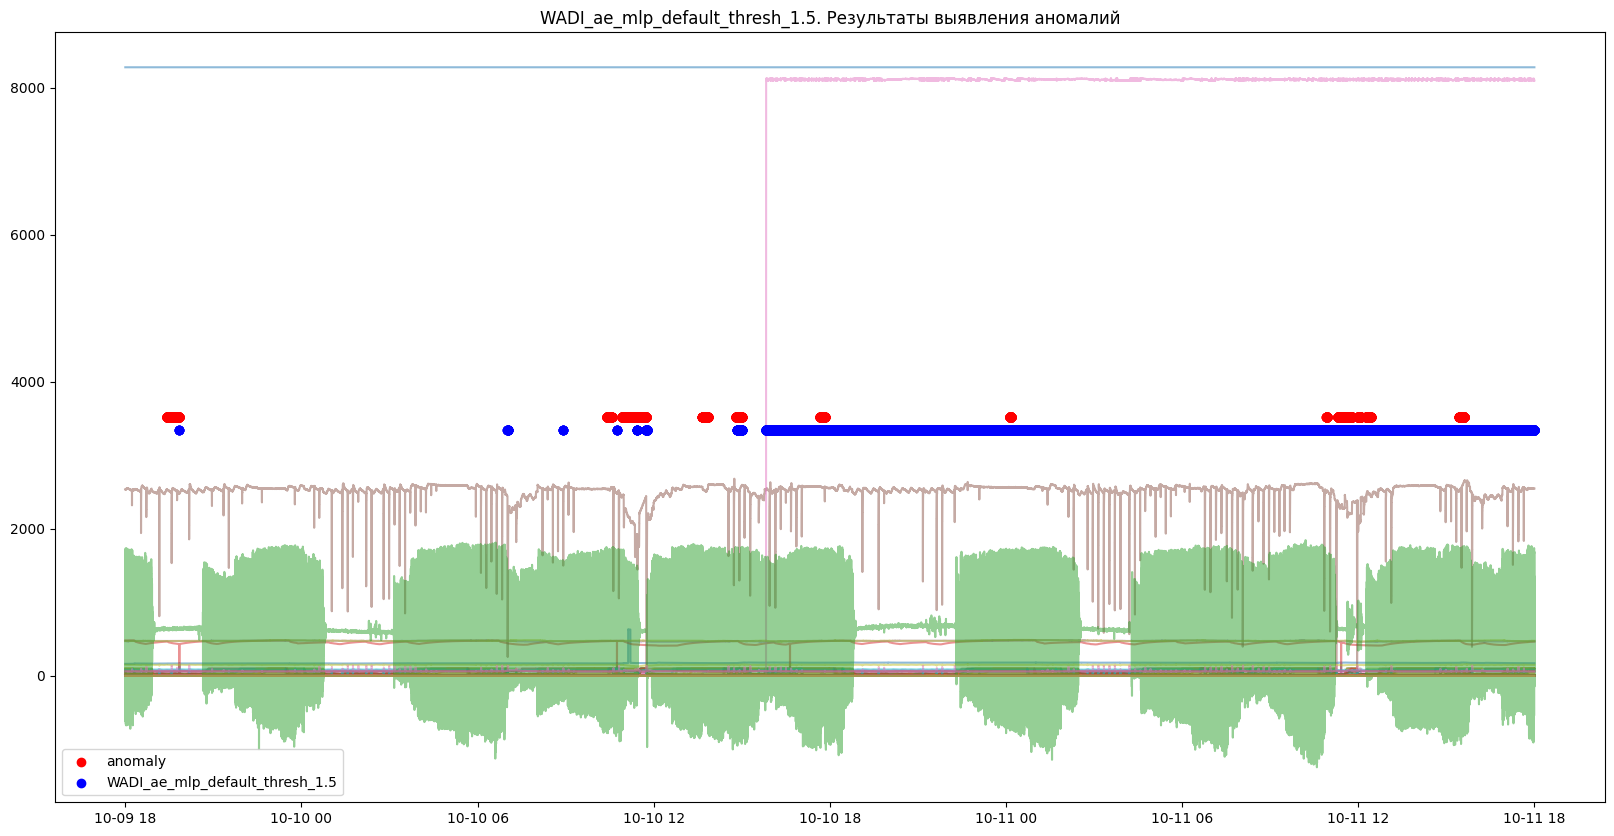

In [37]:
threshold = 1.5

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}_thresh_{threshold}')

In [40]:
description = f'WADI_ae_mlp_wo_badcol_default'

x_train, x_test, y_test = get_traintest(df_train.copy().drop(bad_col, axis=1).dropna(), 
                                        df_test.copy().drop(bad_col, axis=1).dropna())
model = AE_MLP()

predictor = Predictor(model, [x_train, x_test, y_test], 
                      descr=description, 
                      resave_model=False)

Scaling... (Standard)
Количество аномалий: 5.8%

Counter({0: 162824, 1: 9977})
Размеры выборок:
            x_train: (784537, 96)
            x_test: (172801, 96)
            y_test: (172801,)
2022-09-06 19:58:40.432643: can't find saved model, fit model...
784537 96
Epoch 1/10
785/785 [==============================] - 2s 2ms/step - loss: 0.7998
Epoch 2/10
785/785 [==============================] - 2s 2ms/step - loss: 0.7264
Epoch 3/10
785/785 [==============================] - 2s 2ms/step - loss: 0.6948
Epoch 4/10
785/785 [==============================] - 2s 2ms/step - loss: 0.6812
Epoch 5/10
785/785 [==============================] - 2s 2ms/step - loss: 0.6770
Epoch 6/10
785/785 [==============================] - 2s 2ms/step - loss: 0.6745
Epoch 7/10
785/785 [==============================] - 2s 3ms/step - loss: 0.6729
Epoch 8/10
785/785 [==============================] - 2s 2ms/step - loss: 0.6713
Epoch 9/10
785/785 [==============================] - 2s 3ms/step - loss: 0.6698
Epo

Train prediction score statistics
            min: 0.34616052442521655
            mean: 0.5297911704424322
            max: 2.1500810834894786


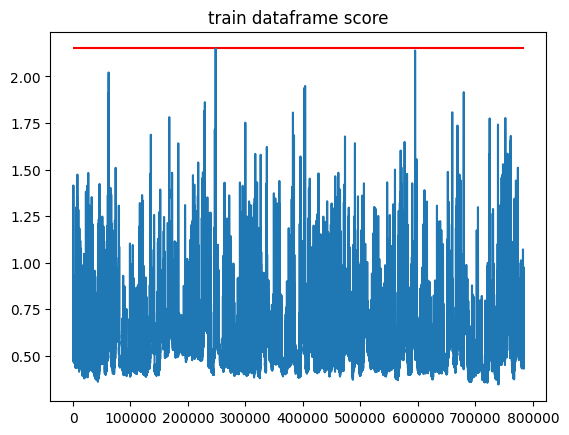

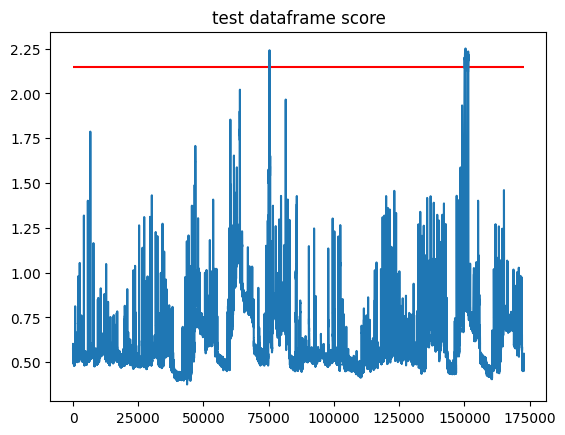

WADI_ae_mlp_wo_badcol_default
f1_score: 0.11
accuracy_score: 0.95
precision_score: 0.99
recall_score: 0.06


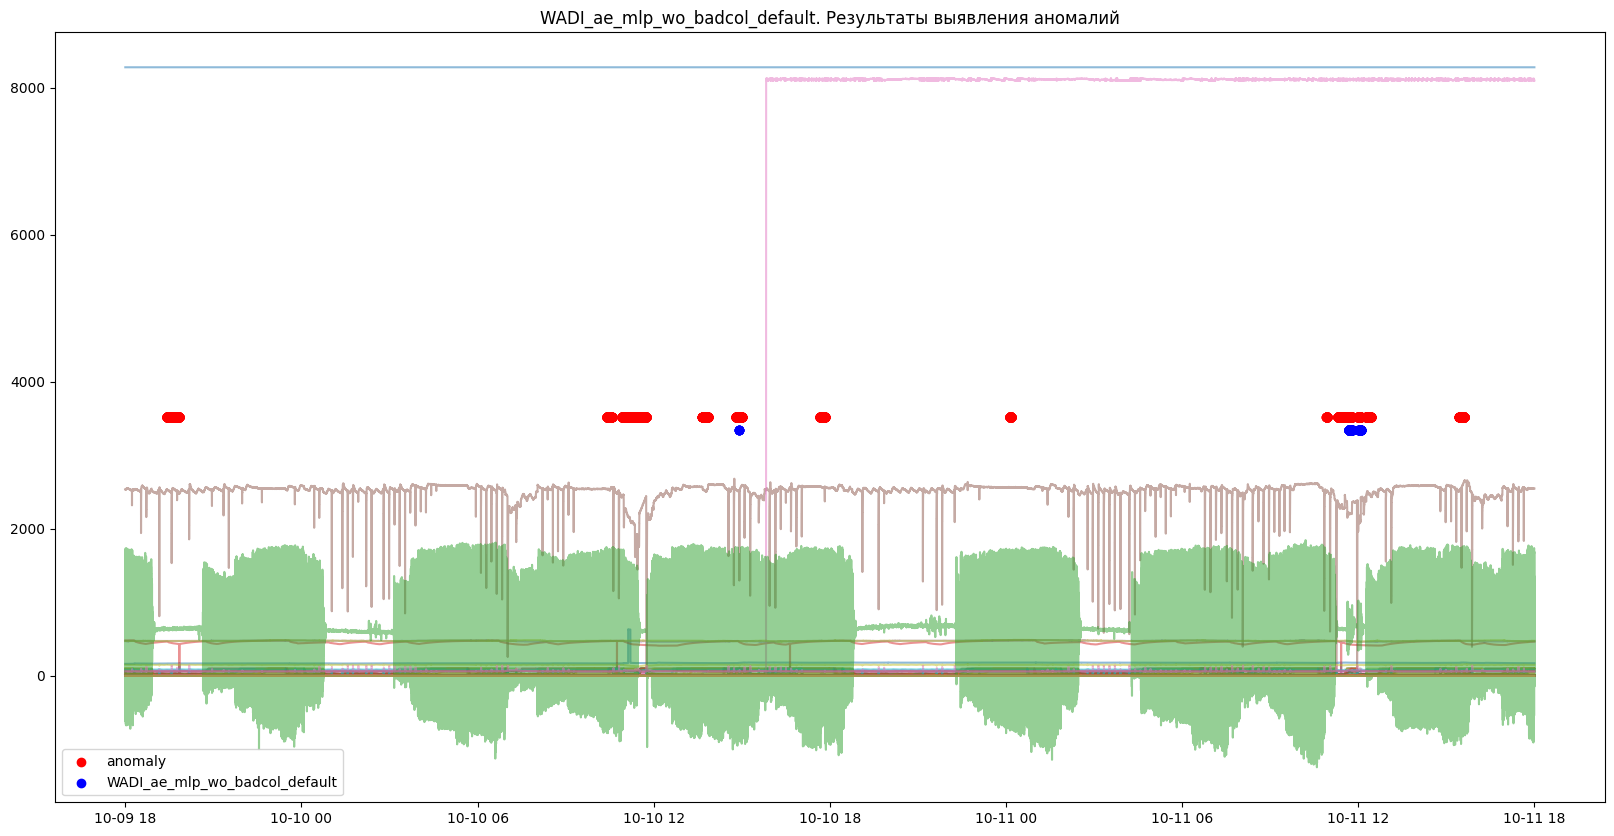

In [41]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}')

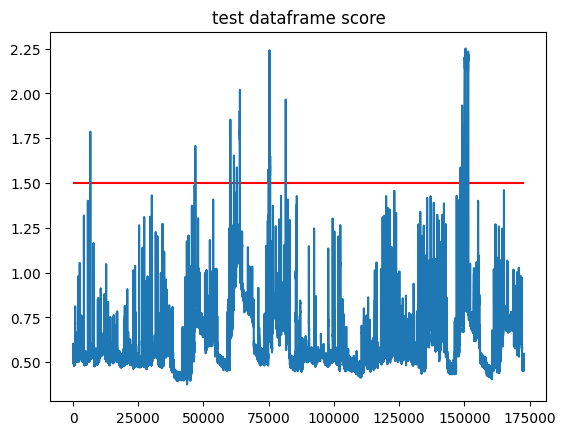

WADI_ae_mlp_wo_badcol_default
f1_score: 0.26
accuracy_score: 0.95
precision_score: 0.86
recall_score: 0.16


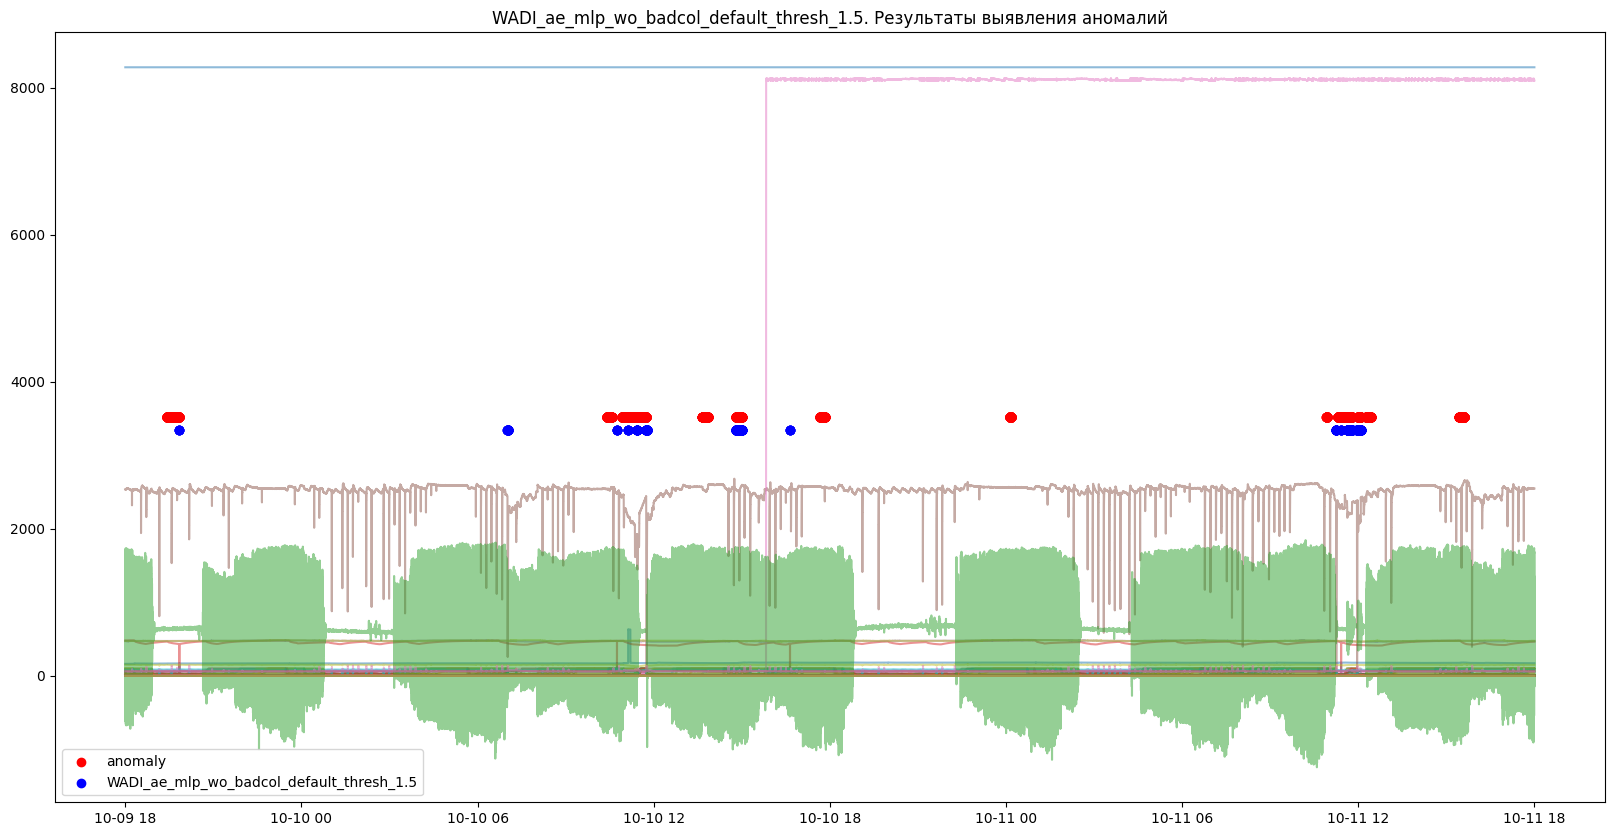

In [42]:
threshold = 1.5

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}_thresh_{threshold}')

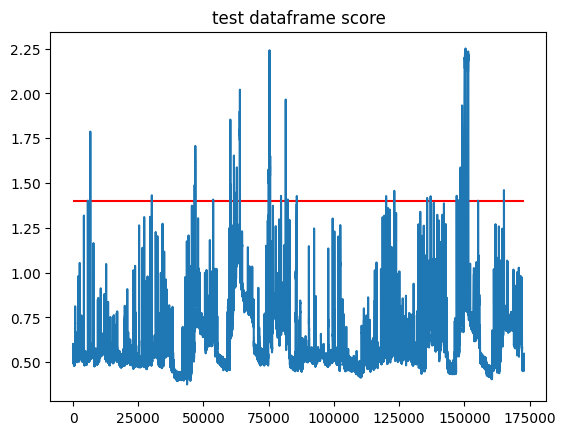

WADI_ae_mlp_wo_badcol_default
f1_score: 0.30
accuracy_score: 0.95
precision_score: 0.81
recall_score: 0.18


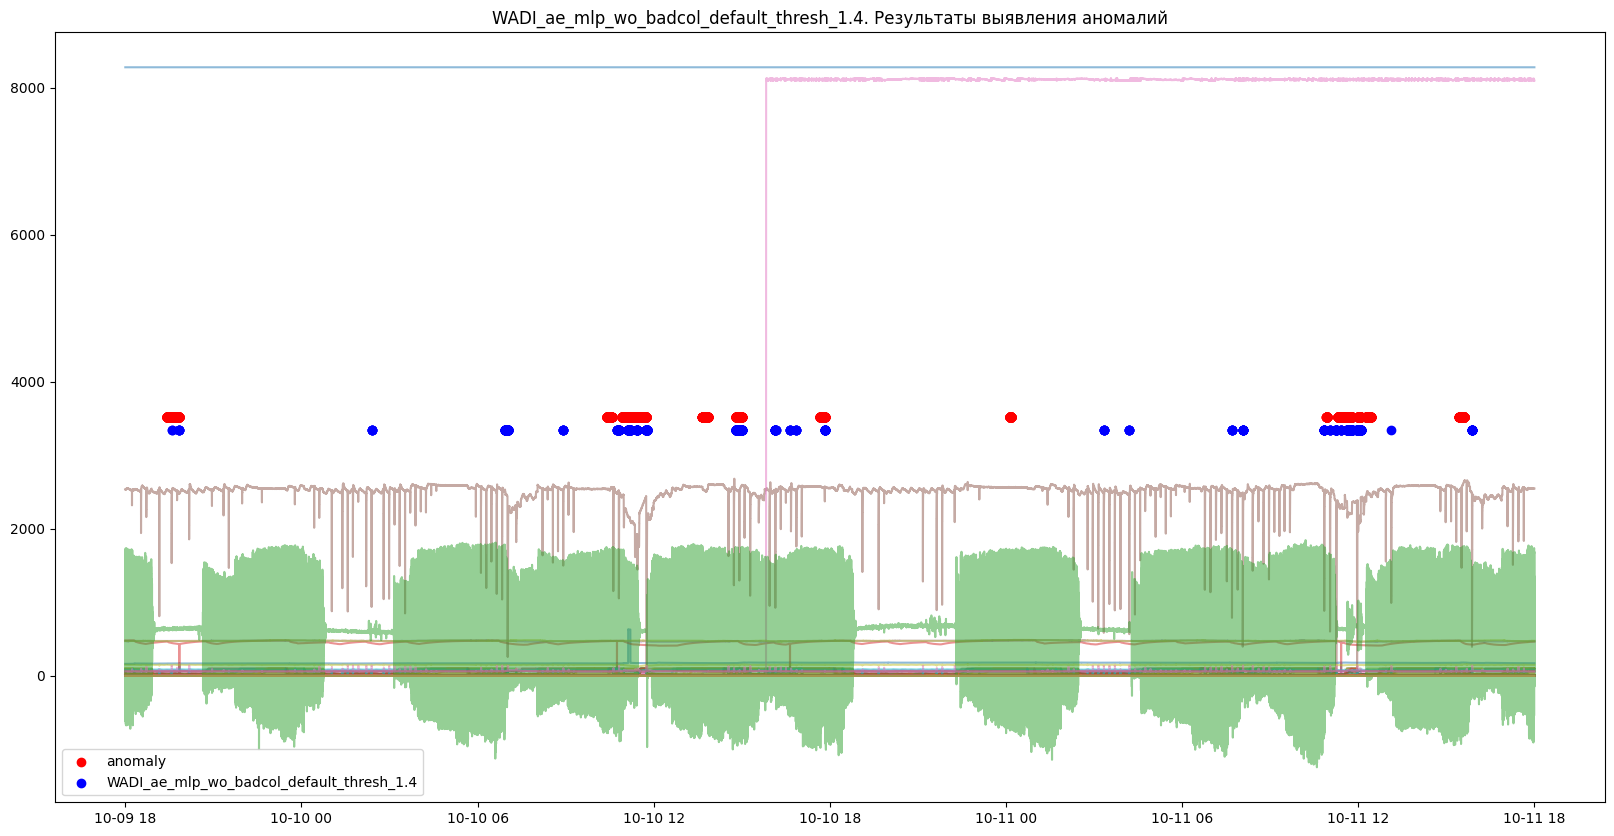

In [44]:
threshold = 1.4

y_pred = predictor.get_anomalies(threshold=threshold)
summary[f'{description}_thresh_{threshold}'] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f'{description}_thresh_{threshold}')

# Сводная таблица

In [45]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.format("{0:,.2f}").background_gradient(cmap='Blues')

,f1_score,accuracy_score,precision_score,recall_score
WADI_svm_default,0.10,0.45,0.05,0.51
WADI_svm_wo_badcol,0.39,0.95,0.71,0.27
WADI_svm_wo_badcol_minmax,0.48,0.95,0.58,0.42
WADI_lof_wo_badcol_n5,0.00,0.94,1.00,0.00
WADI_lof_wo_badcol_n5_thresh_-20,0.33,0.94,0.52,0.24
WADI_iF_default,0.00,0.94,0.03,0.00
SWAT_Jul19_iF_n_98_c_004,0.30,0.90,0.25,0.38
WADI_ae_lstm_window10_resample_T,0.08,0.44,0.04,0.39
WADI_ae_lstm_wo_badcol_window_10_resample_1T_thresh_180,0.31,0.95,0.90,0.19
WADI_ae_lstm_wo_badcol_window_10_resample_1T_minmax,0.45,0.95,0.68,0.34
